# Food Ordering and Delivery 

**Objective:**  
The goal in logistic is to make Average of delivery time of each zone less than 23 mins, and the total cost is fixed.  
  
**Questions:**
+ How much the *CPO should be during *peak / off-peak time for each zone, to affect rider behavior and hit the logitic target? Why?
+ Are there any other key findings from this data can also help achieve the goal?
+ What external factors do you think have not been considered in this data?
+ And what will you do if you have them?

# Assumption:  
+ planned_rh: The expected time spent for all drivers from pickup orders to arrive at customer in a given region and specific time
+ actual_rh: The actual time spent for all drivers from pickup orders to arrive at customer in a given region and specific time
+ total_payment:  
    + qual to CPO here.  
    + Avg.CPO = total_payment / orders 
+ Interval_idle_rh: The overall timeframe drivers is idling, which is [planned_rh] - [actual_rh]
+ Day_of_week: Assuming the weekday or weekend would make no difference in this scenario


## Import Libraries and Read data

In [2]:
# import libraries for data manipulation
import numpy as np
import pandas as pd
# import libraries for data visualization
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

In [3]:
# Read the DataSet
df_orig = pd.read_csv("foodpanda_interview.csv")
df = df_orig.copy()

In [4]:
# to show the full columns display 
pd.set_option('display.max_columns', None)

In [5]:
df.head()

report_date  hour  is_in_peak_time country_name zone_name  orders  \
0      9/7/20     6            False  Philippines  Caloocan    42.0   
1     9/14/20    22            False  Philippines    Manila   479.0   
2     9/22/20    14            False  Philippines    Manila   934.0   
3     9/10/20    18             True  Philippines      Cebu  1281.0   
4     9/19/20     0            False  Philippines   Bacolod    68.0   

   planned_rh   actual_rh  late_show_rh  leave_early_rh  no_show_rh  \
0   21.500000   12.372222      3.796111        0.000000    6.500000   
1  227.137778  189.010278      3.858611        1.060833   41.387778   
2  363.913611  338.435278     10.809444        0.250278   39.250000   
3  524.131111  438.267778     26.362778        1.233889   61.500000   
4   22.500000   20.843333      0.013333        0.000000    3.750000   

   dispatching_time  riders       utr  total_payment    avg. dt  \
0        172.466667    16.0  3.394701        3069.98  21.010938   
1       1647.466667   168.0  2.534254       28892.58  20.628081   
2       2750.183333   367.0  2.759760       56501.92  19.237518   
3      13525.416670   436.0  2.922871       94755.37  33.078522   
4        874.583333    19.0  3.262434        5224.59  31.667164   

   acceptance_rate  delivery_delay_10_orders  estimated_courier_delay  \
0         1.000000                       1.0                    241.0   
1         0.878403                      31.0                   3089.0   
2         0.905860                      28.0                   5511.0   
3         0.888276                     214.0                  21244.0   
4         0.894737                       8.0                   1133.0   

   rider_delay_10_orders  actual_rh_rate   Avg. CPO  
0                    2.0        0.575452  73.094762  
1                    6.0        0.832139  60.318539  
2                    5.0        0.929988  60.429861  
3                   86.0        0.836180  73.912145  
4                    5.0        0.926370  76.832206

In [6]:
# 3600 rows and 22 columns
df.shape

(3600, 22)

df.info()

## Data Sanitation check

In [7]:
# Check for missing values
df.isnull().sum() 

report_date                   0
hour                          0
is_in_peak_time               0
country_name                  0
zone_name                     0
orders                       40
planned_rh                    0
actual_rh                     0
late_show_rh                  0
leave_early_rh                0
no_show_rh                    0
dispatching_time             40
riders                       40
utr                          43
total_payment                45
avg. dt                       0
acceptance_rate              40
delivery_delay_10_orders    187
estimated_courier_delay      40
rider_delay_10_orders       669
actual_rh_rate               17
Avg. CPO                     45
dtype: int64

+ There are 40 numbers of time of report date that do not have any order made
+ There are 45 numbers of orders that do not have total payment and corresponding Avg.CPO

In [8]:
df_orders_nan = df[df['orders'].isnull()]
df_orders_nan.head(10)

report_date  hour  is_in_peak_time country_name zone_name  orders  \
5       9/1/20     4            False        Japan     Tokyo     NaN   
6      9/30/20     4            False        Japan     Tokyo     NaN   
7      9/10/20     4            False  Philippines   Bacolod     NaN   
8      9/13/20     4            False  Philippines   Bacolod     NaN   
9      9/12/20     5            False  Philippines   Bacolod     NaN   
10      9/1/20     5            False  Philippines   Bacolod     NaN   
11     9/16/20     5            False  Philippines   Bacolod     NaN   
12     9/27/20     5            False  Philippines   Bacolod     NaN   
13     9/25/20     4            False  Philippines  Caloocan     NaN   
14     9/23/20     4            False  Philippines   Bacolod     NaN   

    planned_rh  actual_rh  late_show_rh  leave_early_rh  no_show_rh  \
5         2.25   1.000000           0.0             0.0        1.25   
6         7.00   1.000000           0.5             0.0        3.00   
7         0.00   0.429722           0.0             0.0        0.00   
8         1.00   0.000000           0.0             0.0        0.00   
9         2.00   1.000000           0.0             0.0        0.00   
10        1.00   0.000000           0.0             0.0        1.00   
11        1.00   0.000000           0.0             0.0        1.00   
12        2.00   0.000000           0.0             0.0        2.00   
13        4.75   2.000000           0.0             0.0        2.75   
14        0.00   0.000000           0.0             0.0        0.00   

    dispatching_time  riders  utr  total_payment  avg. dt  acceptance_rate  \
5                NaN     NaN  NaN            NaN      0.0              NaN   
6                NaN     NaN  NaN            NaN      0.0              NaN   
7                NaN     NaN  NaN            NaN      0.0              NaN   
8                NaN     NaN  NaN            NaN      0.0              NaN   
9                NaN     NaN  NaN            NaN      0.0              NaN   
10               NaN     NaN  NaN            NaN      0.0              NaN   
11               NaN     NaN  NaN            NaN      0.0              NaN   
12               NaN     NaN  NaN            NaN      0.0              NaN   
13               NaN     NaN  NaN            NaN      0.0              NaN   
14               NaN     NaN  NaN            NaN      0.0              NaN   

    delivery_delay_10_orders  estimated_courier_delay  rider_delay_10_orders  \
5                        NaN                      NaN                    NaN   
6                        NaN                      NaN                    NaN   
7                        NaN                      NaN                    NaN   
8                        NaN                      NaN                    NaN   
9                        NaN                      NaN                    NaN   
10                       NaN                      NaN                    NaN   
11                       NaN                      NaN                    NaN   
12                       NaN                      NaN                    NaN   
13                       NaN                      NaN                    NaN   
14                       NaN                      NaN                    NaN   

    actual_rh_rate  Avg. CPO  
5         0.444444       NaN  
6         0.142857       NaN  
7              NaN       NaN  
8         0.000000       NaN  
9         0.500000       NaN  
10        0.000000       NaN  
11        0.000000       NaN  
12        0.000000       NaN  
13        0.421053       NaN  
14             NaN       NaN

In [9]:
df_orders_nan.iloc[:,[0,1,4,5,14,15,21]].head()

report_date  hour zone_name  orders  total_payment  avg. dt  Avg. CPO
5      9/1/20     4     Tokyo     NaN            NaN      0.0       NaN
6     9/30/20     4     Tokyo     NaN            NaN      0.0       NaN
7     9/10/20     4   Bacolod     NaN            NaN      0.0       NaN
8     9/13/20     4   Bacolod     NaN            NaN      0.0       NaN
9     9/12/20     5   Bacolod     NaN            NaN      0.0       NaN

+ We can tell when order is NaN, we either don't have values in features 'Avg.dt' & 'Avg. CPO', which we care about in this case
+ Therefore we will remove those necessary records

In [10]:
# Remove the row that had orders = NaN
df.drop(df[df['orders'].isnull()].index, inplace=True)

In [11]:
df.shape

(3560, 22)

+ Now the rows count from 3600 to 3560

In [12]:
# Using method 'describe' to get a 22 number of statistical summary with round to restrict decimal places and transpose
df.describe().round(3).T

count       mean        std      min       25%  \
hour                      3560.0     11.580      6.920    0.000     6.000   
orders                    3560.0    422.659    446.171    1.000    98.000   
planned_rh                3560.0    161.663    155.051    0.000    46.000   
actual_rh                 3560.0    131.462    133.838    0.000    33.446   
late_show_rh              3560.0      7.012      8.599    0.000     1.053   
leave_early_rh            3560.0      0.145      0.349    0.000     0.000   
no_show_rh                3560.0     25.889     20.680    0.000     9.250   
dispatching_time          3560.0   3772.832   6479.027    0.000   336.713   
riders                    3560.0    136.231    138.540    1.000    35.000   
utr                       3557.0      3.295     10.327    0.174     2.623   
total_payment             3555.0  30356.932  38088.022    0.000  6569.695   
avg. dt                   3560.0     25.877      8.628    0.000    19.625   
acceptance_rate           3560.0      0.926      0.055    0.222     0.904   
delivery_delay_10_orders  3413.0     42.808     63.911    1.000     7.000   
estimated_courier_delay   3560.0   5495.651   9021.543 -619.000   374.000   
rider_delay_10_orders     2931.0     15.576     22.488    1.000     3.000   
actual_rh_rate            3555.0      0.769      0.129    0.000     0.709   
Avg. CPO                  3555.0     69.337     18.195    0.000    60.357   

                                50%        75%         max  
hour                         12.000     18.000      23.000  
orders                      256.500    581.250    2302.000  
planned_rh                  107.751    218.995     683.971  
actual_rh                    84.445    169.929     604.995  
late_show_rh                  4.242      9.724      78.077  
leave_early_rh                0.000      0.039       3.082  
no_show_rh                   20.250     39.250     128.500  
dispatching_time           1271.950   4213.929   67177.567  
riders                       87.000    172.250     613.000  
utr                           3.048      3.552     600.000  
total_payment             16525.850  38039.915  281636.690  
avg. dt                      23.688     29.950     105.317  
acceptance_rate               0.933      0.958       1.000  
delivery_delay_10_orders     19.000     50.000     635.000  
estimated_courier_delay    1863.500   6298.250   83451.000  
rider_delay_10_orders         7.000     18.000     207.000  
actual_rh_rate                0.787      0.854       1.982  
Avg. CPO                     64.313     72.984     376.110

+ The Average Avg.dt time = 25.877 mins
+ The Maximum Avg.dt time = 105.317 mins  
+ The Average total_payment = 30356.932 dollar
+ The Maximum total_payment = 281636.69 dollar
+ The Average Avg. CPO = 69.337 dollar
+ The Maximum Avg. CPO = 376.110 dollar

In [13]:
# no duplicate vlaues
df.duplicated().sum()

0

+ No dupliated records found

### Qustion 1: 
#### How much the *CPO should be during *peak / off-peak time for each zone, to affect rider behavior and hit the logitic target? Why?

In [14]:
# CPO = cost per order = 'total _payment'  here
# Avg.CPO = total_payment / orders 
df.groupby(['zone_name', 'is_in_peak_time'], as_index=True)['total_payment', 'Avg. CPO'].sum().reset_index()

/var/folders/gj/99_vhdtj3qj2g3jw_pd_2jbc0000gn/T/ipykernel_32511/612789544.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df.groupby(['zone_name', 'is_in_peak_time'], as_index=True)['total_payment', 'Avg. CPO'].sum().reset_index()


zone_name  is_in_peak_time  total_payment      Avg. CPO
0   Bacolod            False     4626753.93  40271.168848
1   Bacolod             True     3402456.37   9628.880225
2  Caloocan            False     7234422.89  40117.512257
3  Caloocan             True     4494469.45   7549.787205
4      Cebu            False    24043727.04  38592.056825
5      Cebu             True    14457712.51   9785.235849
6    Manila            False    21818962.36  39733.952030
7    Manila             True    16998594.49  10472.857985
8     Tokyo            False     6192321.23  41929.106624
9     Tokyo             True     4649471.56   8413.348079

+ In Bacolod:
    + During off-peak time, the CPO of all is <span style='color:lightblue'>(4626753.93)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(40271.168848)</span> dollars
    + During peak time, the CPO of all is <span style='color:lightblue'>(3402456.37)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(9628.880225)</span> dollars
+ In Caloocan:
    + During off-peak time, the CPO of all is <span style='color:lightblue'>(7234422.89)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(40117.512257)</span> dollars
    + During peak time, the CPO of all is <span style='color:lightblue'>(4494469.45)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(7549.787205)</span> dollars
+ In Cebu:
    + During off-peak time, the CPO of all is <span style='color:lightblue'>(24043727.04)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(38592.056825)</span> dollars
    + During peak time, the CPO of all is <span style='color:lightblue'>(14457712.51)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(9785.235849)</span> dollars
+ In Manila:
    + During off-peak time, the CPO of all is <span style='color:lightblue'>(21818962.36)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(39733.952030)</span> dollars
    + During peak time, the CPO of all is <span style='color:lightblue'>(16998594.49)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(10472.857985)</span> dollars
+ In Tokyo:
    + During off-peak time, the CPO of all is <span style='color:lightblue'>(6192321.23)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(41929.106624)</span> dollars
    + During peak time, the CPO of all is <span style='color:lightblue'>(4649471.56)</span> dollars, while Avg.CPO is <span style='color:lightblue'>(8413.348079)</span> dollars

In [15]:
df.groupby(['zone_name', 'is_in_peak_time'], as_index=True)['total_payment'].sum().sort_values(ascending=False).reset_index()

zone_name  is_in_peak_time  total_payment
0      Cebu            False    24043727.04
1    Manila            False    21818962.36
2    Manila             True    16998594.49
3      Cebu             True    14457712.51
4  Caloocan            False     7234422.89
5     Tokyo            False     6192321.23
6     Tokyo             True     4649471.56
7   Bacolod            False     4626753.93
8  Caloocan             True     4494469.45
9   Bacolod             True     3402456.37

+ During Peak time, the highest total cost happened in Manila, which is ***(16998594.49)*** dollars, while the lowest total cost happened in Bacolod, which is ***(3402456.37)*** dollars
+ During off-peak time, the highest total cost happened in Cebu, which is ***(24043727.04)*** dollars, while the lowest total cost happened in Bacolod, which is ***(4626753.93)*** dollars

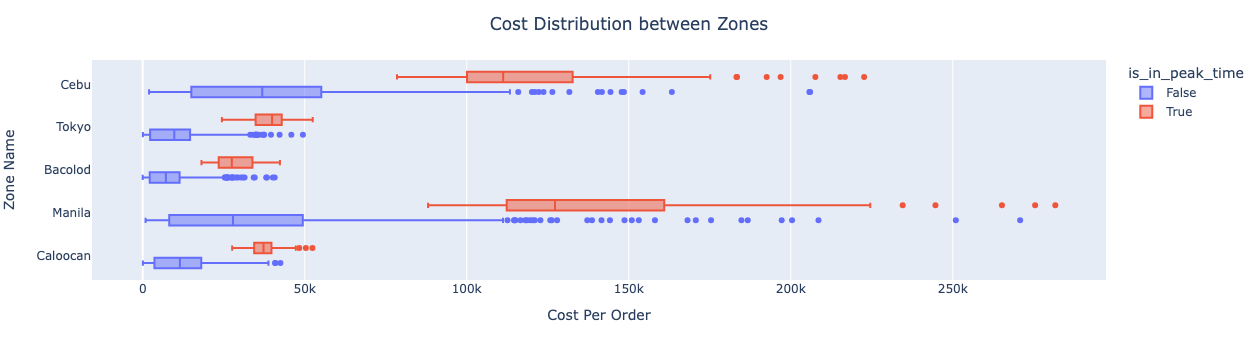

In [16]:
fig = px.box(df,
             x = 'total_payment',
             y = 'zone_name',
             orientation = 'h',
             color = 'is_in_peak_time')
#fig.update_layout(showlegend=False)
fig.update_xaxes(title = 'Cost Per Order')
fig.update_yaxes(title = 'Zone Name')
fig.update_layout(title = 'Cost Distribution between Zones', title_x=0.5)

fig.show()

+ Bacolod has less CPO in both peak time and off-peak time.
+ Manila has the longest range of CPO in peak time, and Cebu has the longest range of CPO in off-peak time

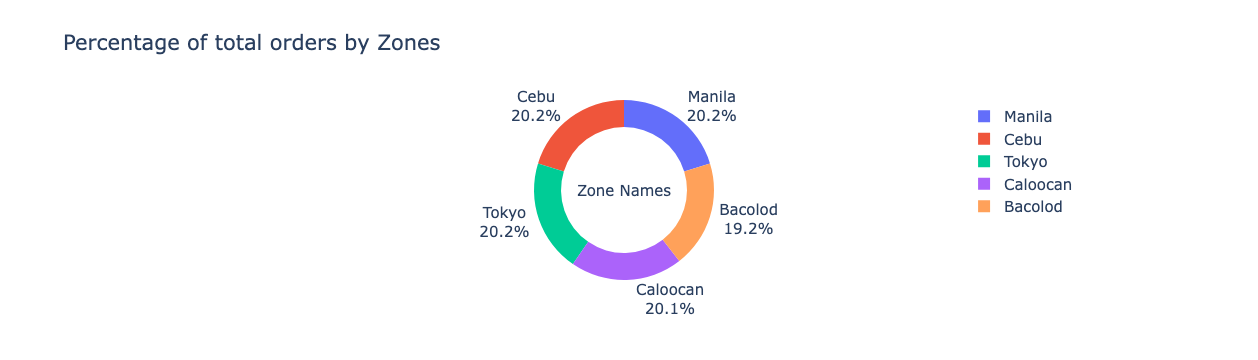

In [17]:
# Analyzing zone_name

df1 = df['zone_name'].value_counts().sort_values(ascending=False).reset_index()

fig = go.Figure(data = [go.Pie(labels = df1['index'],
                               values = df1['zone_name'],
                               hole = .7,
                               title = 'Zone Names')])

fig.update_layout(title = 'Percentage of total orders by Zones', font_size=15)
fig.update_traces(textposition='outside', textinfo='label+percent')

fig.show()

+ Order numbers made by each zone are nearly the same, while Bacolod (19.2%) is the least orders made region.

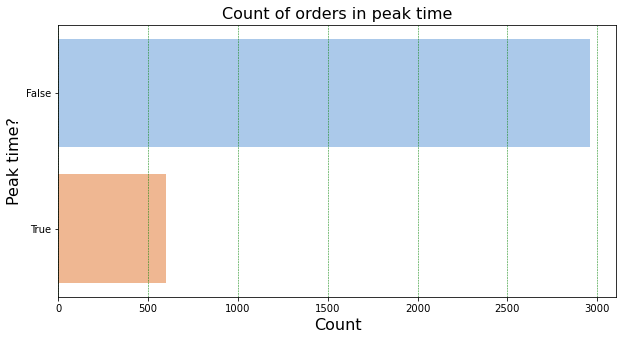

In [18]:
# Analyzing is_in_peak_time

# checking countplot for is_in_peak_time
plt.figure(figsize=(10,5))

sns.countplot(data=df, y='is_in_peak_time', palette='pastel')
plt.xlabel('Count', fontsize=16)
plt.ylabel('Peak time?', fontsize=16)
plt.title('Count of orders in peak time', fontsize=16)
plt.grid(axis='x', color='green', linestyle = '--', linewidth=0.5)

plt.show()

In [19]:
df['is_in_peak_time'].value_counts().reset_index()

index  is_in_peak_time
0  False             2960
1   True              600

In [20]:
# using value counts normalize to get percentage distribution
df['is_in_peak_time'].value_counts(1)*100

False    83.146067
True     16.853933
Name: is_in_peak_time, dtype: float64

+ There are almost 83% orders during off-peak time and almost 17% during off-peak time, which clearly indicate the fact that ***off-peak time*** are very important for business.

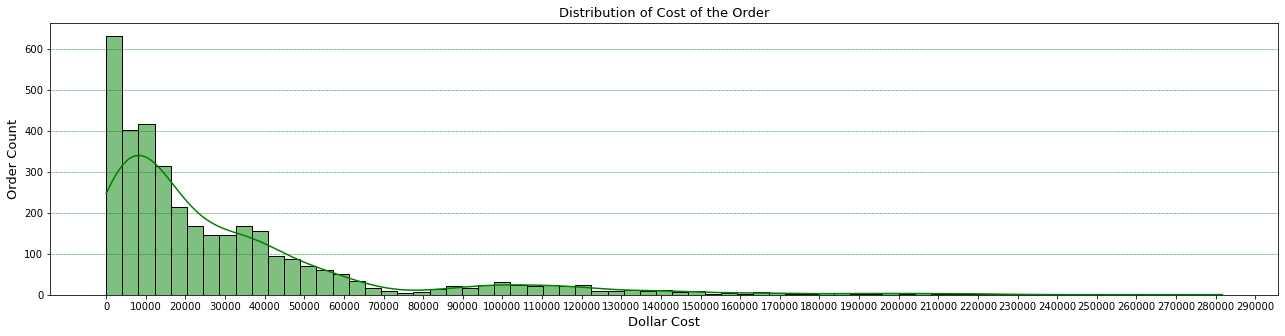

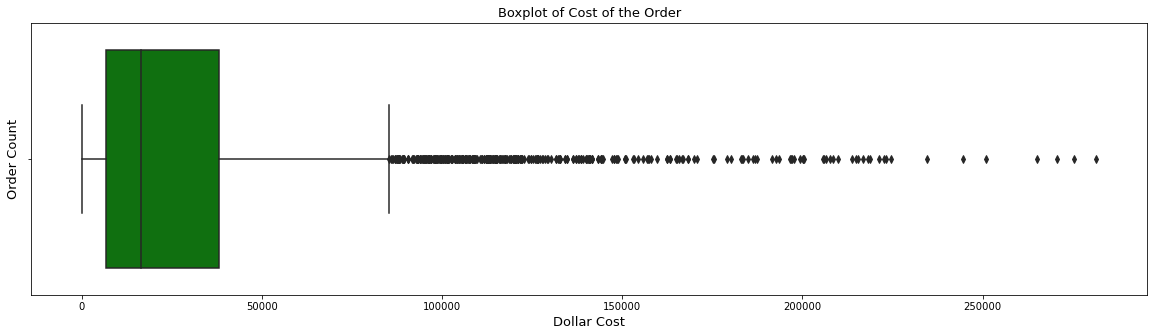

In [21]:
# Analyzing total_payment

# checking histogram for cost of order
plt.figure(figsize=(22,5))

sns.histplot(data=df, x='total_payment', kde=True, color='green')
plt.xlabel('Dollar Cost', fontsize=13)
plt.ylabel('Order Count', fontsize=13)
plt.title('Distribution of Cost of the Order', fontsize=13)
plt.xticks(np.arange(0,300000,10000))
plt.grid(axis='y', color='green', linestyle = '--', linewidth=0.5)

plt.show()

# checking boxplot for cost of order
plt.figure(figsize=(20,5))

sns.boxplot(data=df, x='total_payment', color='green')
plt.xlabel('Dollar Cost', fontsize=13)
plt.ylabel('Order Count', fontsize=13)
plt.title('Boxplot of Cost of the Order', fontsize=13)


plt.show()

In [22]:
df['total_payment'].describe()

count      3555.000000
mean      30356.931598
std       38088.022183
min           0.000000
25%        6569.695000
50%       16525.850000
75%       38039.915000
max      281636.690000
Name: total_payment, dtype: float64

+ The data appears to have few anomalies.
+ Median CPO is approx 16525.85 dollars, while Mean is 30356.93 dollars
+ The KDE line in Histogram and Boxplot indicate skewness towards right.


In [23]:
# creating a new column avf.dt which is less than 23 mins'
df['df_target'] = df['avg. dt'] < 23.0

# adding a new column in the DataFrame which will be the interval of the planned_rh and actual_rh
df['interval_idle_rh'] = df['planned_rh'] - df['actual_rh']
df

report_date  hour  is_in_peak_time country_name zone_name  orders  \
0         9/7/20     6            False  Philippines  Caloocan    42.0   
1        9/14/20    22            False  Philippines    Manila   479.0   
2        9/22/20    14            False  Philippines    Manila   934.0   
3        9/10/20    18             True  Philippines      Cebu  1281.0   
4        9/19/20     0            False  Philippines   Bacolod    68.0   
...          ...   ...              ...          ...       ...     ...   
3595     9/23/20     0            False  Philippines   Bacolod    53.0   
3596      9/5/20     0            False  Philippines    Manila   311.0   
3597     9/14/20     0            False  Philippines   Bacolod    46.0   
3598      9/9/20     0            False  Philippines    Manila   273.0   
3599     9/10/20     0            False  Philippines      Cebu   503.0   

      planned_rh   actual_rh  late_show_rh  leave_early_rh  no_show_rh  \
0      21.500000   12.372222      3.796111        0.000000    6.500000   
1     227.137778  189.010278      3.858611        1.060833   41.387778   
2     363.913611  338.435278     10.809444        0.250278   39.250000   
3     524.131111  438.267778     26.362778        1.233889   61.500000   
4      22.500000   20.843333      0.013333        0.000000    3.750000   
...          ...         ...           ...             ...         ...   
3595   24.750000   17.790556      0.000000        0.000000    7.000000   
3596  130.250000   95.727222      1.483056        0.000000   31.250000   
3597   21.660833   16.491667      0.539167        0.000000    5.000000   
3598  129.000000   97.408056      4.286389        0.003333   26.000000   
3599  223.750000  181.094722      5.817778        0.040278   40.500000   

      dispatching_time  riders       utr  total_payment    avg. dt  \
0           172.466667    16.0  3.394701        3069.98  21.010938   
1          1647.466667   168.0  2.534254       28892.58  20.628081   
2          2750.183333   367.0  2.759760       56501.92  19.237518   
3         13525.416670   436.0  2.922871       94755.37  33.078522   
4           874.583333    19.0  3.262434        5224.59  31.667164   
...                ...     ...       ...            ...        ...   
3595        219.166667    21.0  2.979109        2750.32  18.673077   
3596       1795.150000   105.0  3.248815       17964.00  23.344175   
3597        387.633333    13.0  2.789288        3293.79  28.655797   
3598       1543.400000    88.0  2.802643       17191.60  22.907692   
3599       1719.266667   183.0  2.777552       30067.76  19.586761   

      acceptance_rate  delivery_delay_10_orders  estimated_courier_delay  \
0            1.000000                       1.0                    241.0   
1            0.878403                      31.0                   3089.0   
2            0.905860                      28.0                   5511.0   
3            0.888276                     214.0                  21244.0   
4            0.894737                       8.0                   1133.0   
...               ...                       ...                      ...   
3595         0.929825                       1.0                    331.0   
3596         0.884181                      23.0                   2298.0   
3597         0.978723                       2.0                    597.0   
3598         0.872671                      18.0                   1820.0   
3599         0.902135                       6.0                   3386.0   

      rider_delay_10_orders  actual_rh_rate   Avg. CPO  df_target  \
0                       2.0        0.575452  73.094762       True   
1                       6.0        0.832139  60.318539       True   
2                       5.0        0.929988  60.429861       True   
3                      86.0        0.836180  73.912145      False   
4                       5.0        0.926370  76.832206      False   
...                     ...             ...        ...     

In [24]:
df['df_target'].value_counts()

False    1925
True     1635
Name: df_target, dtype: int64

In [25]:
#<23 min order的有多少
df_target_order = df.groupby(['df_target'])['orders'].sum().sort_values(ascending=False).reset_index()
df_target_order

df_target    orders
0      False  979046.0
1       True  525620.0

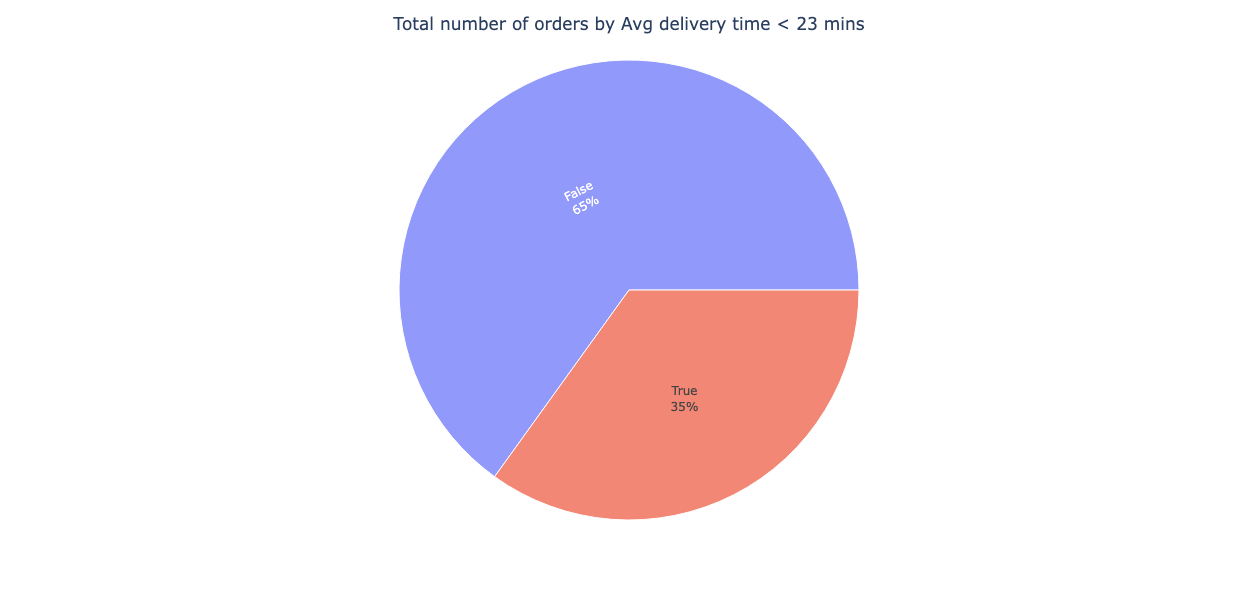

In [26]:
fig = px.sunburst(df_target_order,
                  path=['df_target'],
                  values='orders')

fig.update_layout(autosize=False, height=600, width=1000)
fig.update_layout(title='Total number of orders by Avg delivery time < 23 mins', title_x=0.5)
fig.update_traces(textinfo = 'label+percent parent')

fig.show()

+ We can observe that 35% of given data achieve the target, which id Avg delivery time less than 23 mins

### Qustion 2: 
### Objective:
The goal in logistic is to make Average of delivery time of each zone less than 23 mins, and the total cost is fixed.
### Are there any other key findings from this data can also help achieve the goal?

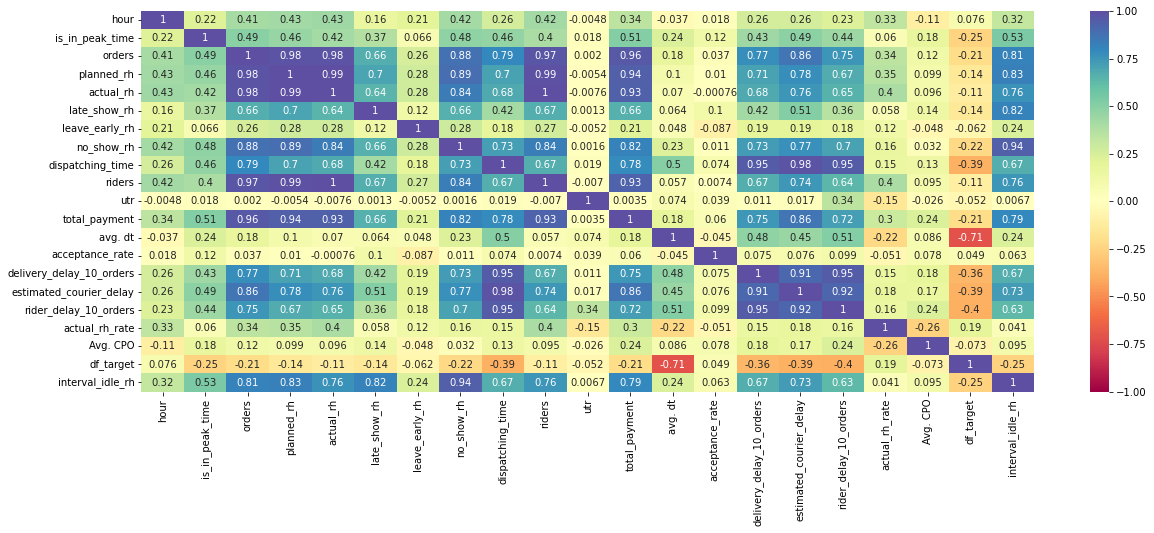

In [27]:
# check correlation map to see if any correlation is there
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(),annot=True,cmap='Spectral',vmin=-1,vmax=1)
plt.show()

It appears that total_payment(CPO) has significant correlation with 'orders', 'planned_rh', 'actual_rh', 'riders', and 'estimated_courier_delay'.

* orders: the more orders, the more CPO we need to put in

* planned_rh, actual_rh:  
However, based on assumption, only having 'planned_rh' and 'actual_rh' cannot sufficiently describe the rider behavior, 
instead newly created 'interval_idle_rh' column can tell more in terms of the fact that when interval is heigher representing more idle riders need for next pick-up, the CPO would be getting higher.

* riders: the more riders out, the more CPO we need to pay to them
* estimated_courier_delay: the more time courier delay, the more CPO we have

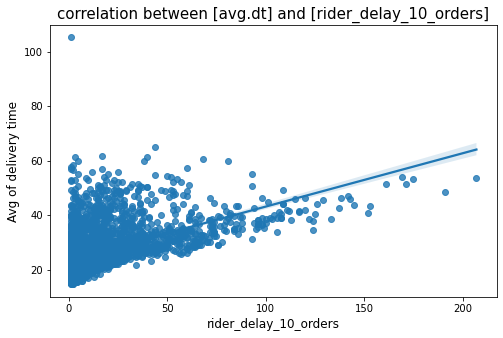

In [28]:
# correlation between [avg.dt] and [rider_delay_10_orders]

plt.figure(figsize=(8,5))

sns.regplot(x='rider_delay_10_orders', y='avg. dt', data=df)

plt.xlabel('rider_delay_10_orders', fontsize=12)
plt.ylabel('Avg of delivery time', fontsize=12)
plt.title('correlation between [avg.dt] and [rider_delay_10_orders]', fontsize=15)

plt.show()

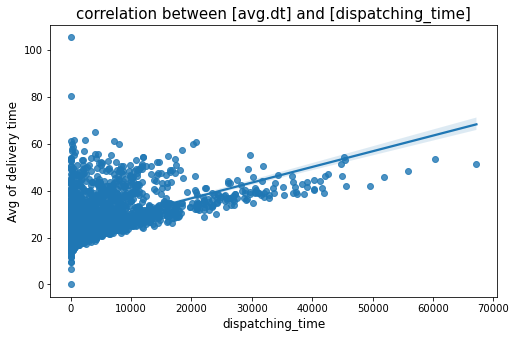

In [29]:
# correlation between [avg.dt] and [dispatching_time]

plt.figure(figsize=(8,5))

sns.regplot(x='dispatching_time', y='avg. dt', data=df)

plt.xlabel('dispatching_time', fontsize=12)
plt.ylabel('Avg of delivery time', fontsize=12)
plt.title('correlation between [avg.dt] and [dispatching_time]', fontsize=15)

plt.show()

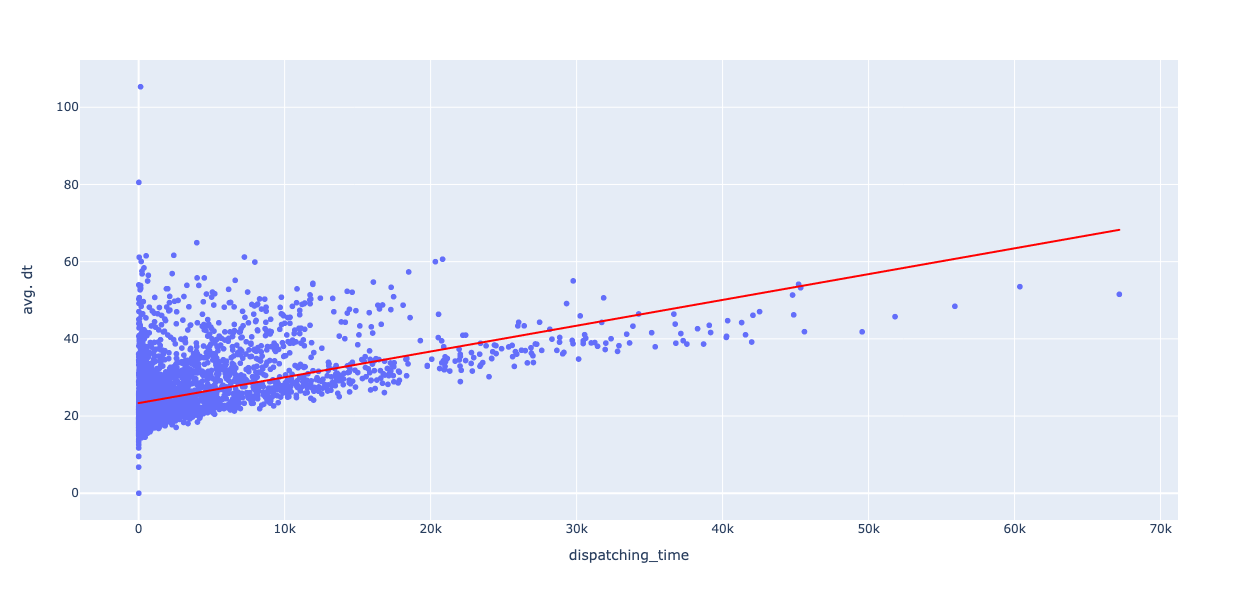

In [30]:
fig = px.scatter(df, x='dispatching_time', y='avg. dt', trendline='ols', trendline_color_override='red')
fig.update_layout(autosize=False, height=600, width=1200)

+ Positive Correlation between [Avg.dt] and [rider_delay_10_orders] as well as [Avg.dt] and [dispatching_time] 
+ It represents that the less number of rider_delay_10_orders, the less Avg delivery time we will have, which is more likely to achieve that less than 23 mins
+ It represents that the less number of dispatching_time, the less Avg delivery time we will have, which is more likely to achieve that less than 23 mins

In [31]:
# Find the total number of reviews groupby subjects
avgdt_df = df.groupby(['zone_name'])['avg. dt'].sum().sort_values(ascending=False).reset_index()

avgdt_df

zone_name       avg. dt
0   Bacolod  20693.760832
1      Cebu  19205.690544
2    Manila  19152.114360
3  Caloocan  18043.233600
4     Tokyo  15025.825107

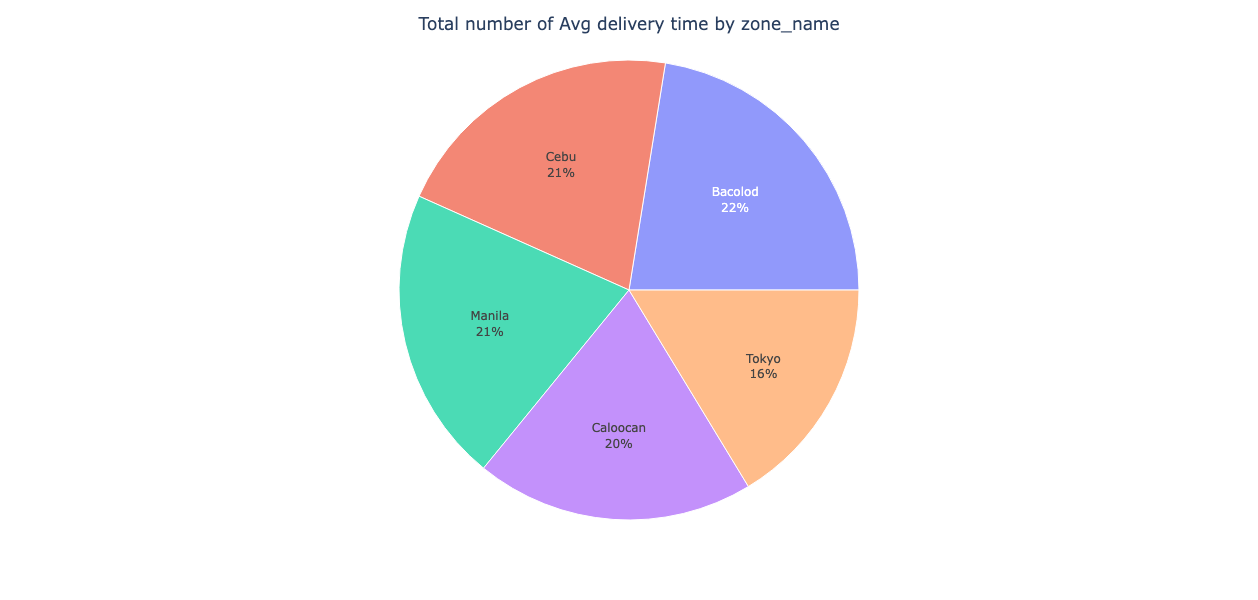

In [32]:
fig = px.sunburst(avgdt_df,
                  path=['zone_name'],
                  values='avg. dt')

fig.update_layout(autosize=False, height=600, width=1000)
fig.update_layout(title='Total number of Avg delivery time by zone_name', title_x=0.5)
fig.update_traces(textinfo = 'label+percent parent')

fig.show()

In [33]:
# Find the total number of reviews groupby subjects

rider_delay_10_orders_df = df.groupby(['zone_name'])['rider_delay_10_orders'].sum().sort_values(ascending=False).reset_index()

rider_delay_10_orders_df

zone_name  rider_delay_10_orders
0      Cebu                16864.0
1    Manila                15613.0
2  Caloocan                 6223.0
3   Bacolod                 4913.0
4     Tokyo                 2039.0

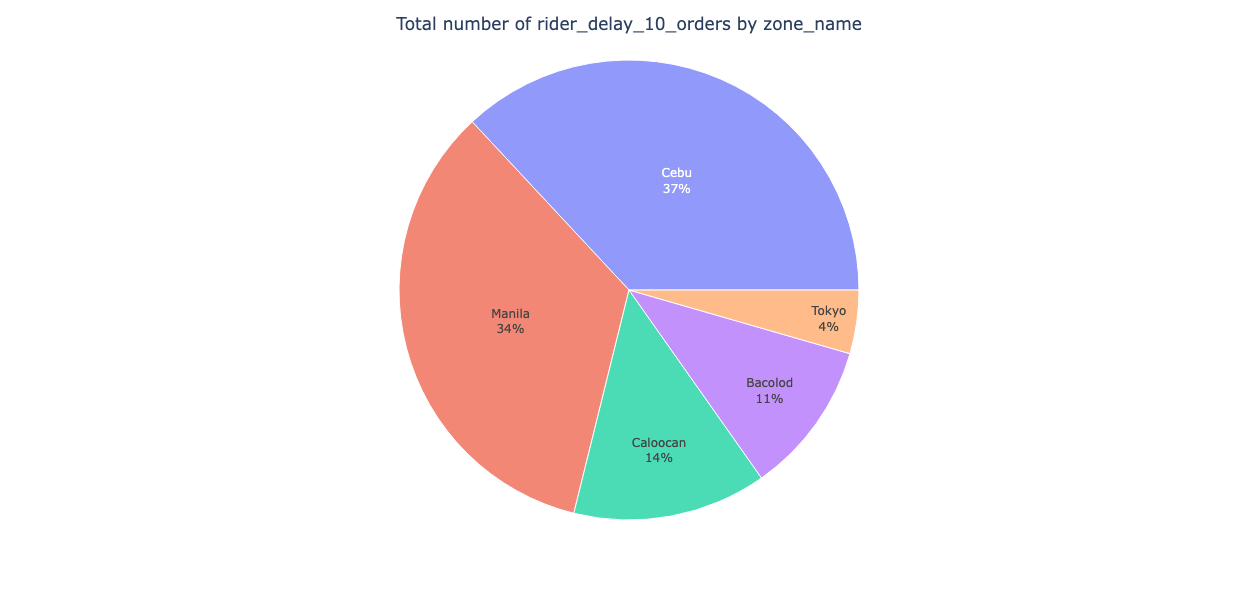

In [34]:
fig = px.sunburst(rider_delay_10_orders_df,
                  path=['zone_name'],
                  values='rider_delay_10_orders')

fig.update_layout(autosize=False, height=600, width=1000)
fig.update_layout(title='Total number of rider_delay_10_orders by zone_name', title_x=0.5)
fig.update_traces(textinfo = 'label+percent parent')

fig.show()